In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math as ma
import cmath as cm
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib qt
plt.rcParams['animation.html'] = 'jshtml'
plt.rcParams.update({'font.size': 9})

In [2]:
%matplotlib inline
from IPython.display import clear_output

# 1. Обучение модели однослойного robust чипа

In [4]:
def mega_arr_create_exp (path = '', ch = [1, 2, 3, 4], H = [1, 2, 3]):
    X = []
    Y = []
    for i in ch:
        for j in H:
            file = f'.{path}/channel_{i}/Ch{i}_H{j}.txt'
            exp_data = np.loadtxt(file)
            for row in exp_data:
                curr = [0,0,0]
                curr[j-4] = row[0]
                el = [i,curr]
                X.append(el)
                y=row[1:]
                y=y/np.sum(y)
                y=y.tolist()
                Y.append(y)
    return X,Y

In [5]:
X,Y = mega_arr_create_exp()
Y = torch.FloatTensor(Y)

In [6]:
X

[[1, [0.0, 0, 0]],
 [1, [10.0, 0, 0]],
 [1, [20.0, 0, 0]],
 [1, [30.0, 0, 0]],
 [1, [40.0, 0, 0]],
 [1, [50.0, 0, 0]],
 [1, [60.0, 0, 0]],
 [1, [70.0, 0, 0]],
 [1, [80.0, 0, 0]],
 [1, [90.0, 0, 0]],
 [1, [100.0, 0, 0]],
 [1, [110.0, 0, 0]],
 [1, [120.0, 0, 0]],
 [1, [130.0, 0, 0]],
 [1, [140.0, 0, 0]],
 [1, [150.0, 0, 0]],
 [1, [160.0, 0, 0]],
 [1, [170.0, 0, 0]],
 [1, [180.0, 0, 0]],
 [1, [190.0, 0, 0]],
 [1, [200.0, 0, 0]],
 [1, [210.0, 0, 0]],
 [1, [220.0, 0, 0]],
 [1, [230.0, 0, 0]],
 [1, [240.0, 0, 0]],
 [1, [250.0, 0, 0]],
 [1, [260.0, 0, 0]],
 [1, [270.0, 0, 0]],
 [1, [280.0, 0, 0]],
 [1, [290.0, 0, 0]],
 [1, [300.0, 0, 0]],
 [1, [310.0, 0, 0]],
 [1, [320.0, 0, 0]],
 [1, [330.0, 0, 0]],
 [1, [340.0, 0, 0]],
 [1, [350.0, 0, 0]],
 [1, [360.0, 0, 0]],
 [1, [370.0, 0, 0]],
 [1, [380.0, 0, 0]],
 [1, [390.0, 0, 0]],
 [1, [400.0, 0, 0]],
 [1, [410.0, 0, 0]],
 [1, [420.0, 0, 0]],
 [1, [430.0, 0, 0]],
 [1, [440.0, 0, 0]],
 [1, [450.0, 0, 0]],
 [1, [460.0, 0, 0]],
 [1, [470.0, 0, 0]],
 [1

In [7]:
Y

tensor([[0.2923, 0.0366, 0.4466, 0.2246],
        [0.2929, 0.0362, 0.4462, 0.2247],
        [0.2921, 0.0368, 0.4467, 0.2243],
        ...,
        [0.1175, 0.3068, 0.3496, 0.2262],
        [0.1332, 0.2791, 0.3973, 0.1904],
        [0.1431, 0.2545, 0.4382, 0.1643]])

In [8]:
f_0 = torch.randn(3,requires_grad=True)
alpha = torch.tensor([[8.39,1.71,-1.71],
                      [2.71,7.39,0],
                      [1,1.71,5.68]], requires_grad=True)
ph_1 = torch.randn(9,requires_grad=True)
ph_2 = torch.randn(9,requires_grad=True)
T_out = torch.tensor([0.5,0.5,0.5,0.5],requires_grad=True)

In [9]:
def P_create(c_0, a, x):
    c = c_0 + a @ x
    P = torch.eye(4, dtype=torch.complex64)
    for i in range(3):
        P[i, i] = torch.exp(1j*c[i])
    return P

def T_pq(N, p, q, theta, phi):
    ''' 
    Creates unitary T_pq matrix
    needed for function Reck_Create
    N - dimension (number of modes)
    p, q - int numbers, where MZI will be placed
    theta, phi - phases in MZI
    '''
    T = torch.eye(N,dtype=torch.complex64)
    T[p,p]=torch.exp(1j*phi)*torch.sin(theta/2)
    T[p,q]=torch.exp(1j*phi)*torch.cos(theta/2)
    T[q,p]=torch.cos(theta/2)
    T[q,q]=-torch.sin(theta/2)
    return T


def U_Create_rb(N, phases):
    ''' 
    Creates REAL BORDERED unitary Reck matrix
    no input/output phases
    N - dimension (number of modes)
    phases - (N - 1)^2 phases in Reck scheme MZIs
        '''
    U=torch.eye(N, dtype=torch.complex64)
    k = 0
    for p in range(N - 1, 0, -1):
        for q in range(p - 1, -1, -1):
            if (p == N - 1):
                U = U @ T_pq(N, p, q, phases[k], torch.tensor(0.))
                k+=1
            else:
                U = U @ T_pq(N, p, q, phases[k], phases[k+1])
                k+=2
    return U

def interf (x):
    a_in = np.zeros((4, 1),dtype='complex64')
    ch = x[0]
    a_in[ch - 1, 0] = 1.
    a_in = torch.from_numpy(a_in)
    multiplier = torch.tensor(1e-6, requires_grad=True)
    alpha_1 = alpha*multiplier
    x_amperage = np.asarray(x[1])**2
    x_amperage =  torch.from_numpy(x_amperage).float()
    P = P_create(f_0, alpha_1, x_amperage)
    M1, M2 = U_Create_rb(4, ph_1), U_Create_rb(4, ph_2)
    U = M2 @ P @ M1
    a_out = U @ a_in
    a_dec = torch.abs(a_out[:, 0])**2
    a_dec_new = a_dec * T_out
    return a_dec_new/torch.sum(a_dec_new)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [11]:
%matplotlib inline
from IPython.display import clear_output

In [12]:
'''
Calculating R2 and MSE Loss between x and y data
x = [channel num, [currents]]
y = torch.tensor([normed output intensities])
'''
def accuracy(x,y):
    mse = []
    preds = []
    for i in range(len(y)):
        mse.append(criterion(interf(x[i]),y[i]).item())
        preds.append(interf(x[i]))
    test_mse=sum(mse)/len(mse) 
    x_1 = torch.cat(preds, dim=0)
    x_1 = torch.flatten(x_1).detach().numpy()
    y=torch.flatten(y).detach().numpy()
    residuals = y - x_1
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return test_mse, r_squared

In [13]:
'''
shuffling data
input: dataset x, y
returns shuffled dataset x_shuffled, y_shuffled
'''
def shuffle(x,y):
    pairs = list(zip(x, y))
    random.shuffle(pairs)
    x_shuffled, y_shuffled = zip(*pairs)
    return x_shuffled, y_shuffled

In [14]:
f_0 = torch.randn(3,requires_grad=True)
alpha = torch.tensor([[8.39,1.71,-1.71],
                      [2.71,7.39,0],
                      [1,1.71,5.68]], requires_grad=True)
ph_1 = torch.randn(9,requires_grad=True)
ph_2 = torch.randn(9,requires_grad=True)
T_out = torch.tensor([0.5,0.5,0.5,0.5],requires_grad=True)

In [15]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam([ alpha,f_0,ph_1,ph_2], lr=0.01)
optimizer1 = torch.optim.Adam([T_out], lr=0.01)
num_epochs = 1000

In [16]:
train_loss_history, test_loss_history = [], []
accuracy_history =[]

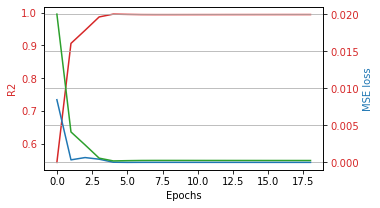

 33%|█████████████████████████▉                                                    | 418/1257 [00:04<00:08, 100.78it/s]


KeyboardInterrupt: 

In [17]:
for epoch in range(num_epochs):
    i=0
    for el in tqdm(X_train):
    # Forward pass and loss calculation
        optimizer.zero_grad()
        optimizer1.zero_grad()
        prediction = interf(el)
        loss = criterion(prediction, y_train[i]) 
    # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer1.step()
        i+=1
    # Save the loss for plotting
    train_loss_history.append(loss.item()) 
    with torch.no_grad():
        test_loss, r2 = accuracy(X_test,y_test)
        test_loss_history.append(test_loss)
        accuracy_history.append(r2)
# Plot the training progress
    clear_output(True)
    fig, ax1 = plt.subplots(figsize=(5,3))
    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('R2', color=color)
    ax1.plot(np.arange(len(accuracy_history)), accuracy_history, color=color, label = 'accuracy')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color1 = 'tab:blue'
    color2 = 'tab:green'
    ax2.set_ylabel('MSE loss', color=color1)
    ax2.plot(np.arange(len(train_loss_history)), train_loss_history, color=color1, label = 'train mse')
    ax2.plot(np.arange(len(test_loss_history)), test_loss_history, color=color2, label = 'test mse')
    ax2.tick_params(axis='y', labelcolor=color)
    plt.grid()
    plt.show()

In [18]:
print(f_0)
print(alpha) 
print(ph_1)
print(ph_2)
print(T_out)

tensor([ 0.2730, -2.0120,  1.0329], requires_grad=True)
tensor([[ 9.4635,  2.1357, -2.7764],
        [ 3.8289,  8.4299, -0.4458],
        [ 1.4179,  2.4470,  6.0399]], requires_grad=True)
tensor([ 1.0737, -1.5554, -2.0898, -1.0614,  2.2363, -1.5628, -1.0183, -1.1048,
        -2.0005], requires_grad=True)
tensor([-1.1261, -1.5155,  1.8710,  0.9923,  2.2342, -1.5785, -0.9094,  1.1197,
        -1.8846], requires_grad=True)
tensor([1.1416, 1.6431, 1.5527, 1.3080], requires_grad=True)


In [65]:
accuracy(X,Y)

(0.0005867590754562285, 0.9883525567129254)